In [25]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *


import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt

from fractions import Fraction
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor


# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-03-29 14:19:12,688: Credentials are already in use. The existing account in the session will be replaced.


In [17]:
simulator = qk.BasicAer.get_backend('qasm_simulator')
real = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits > 4,
                                            operational=True, simulator=False))
print(real)

ibmq_quito


### A Bernstein-Vazarini Probléma

Adott egy feketedoboz függvény ami egy $\underline{x} = (x_1, x_2, ..., x_n)$ bitsorhoz rendel hozzá 0-t vagy 1-et:<br><br>\begin{equation}
f(x_1, x_2, ..., x_n) = 0 \text{ or } 1.
\end{equation}
(Minden $i$-re $x_i$ 0 vagy 1.) Tudjuk, hogy a függvény minden $\underline{x}$ bitsor esetén egy $\underline{s}$ bitsorral vett bitenkénti szorzatának 2 szerinti maradékát adja vissza. A bitenkénti szorzat alatt a következő műveletet értjük: $\underline{s}\cdot\underline{x} = x_1\cdot s_1 +x_2\cdot s_2 +...+x_n\cdot s_n$. Tehát a függvényt a következő alakban írható fel: $f(\underline{x}) = \underline{s}\cdot\underline{x} \text{ mod } 2$. Az a feladat, hogy találjuk ki, hogy mi az $\underline{s}$ bitsor.<br>

**1. feladat** 

Gondoljuk végig, hogy hogyan oldanánk meg A Berstein-Vazarini problémát egy klasszikus számítógéppel. Hányszor kéne ehhez elvégezni az $f$ függvényt megvalósító műveletet?

In [18]:
n = 4
s = np.random.randint(0, 2, n)

def f(x, s): # x egy és s azonos hosszúságú numpy array-ok
    if len(x) != n:
        raise ValueError("x and s have to be of the same length")
    return np.dot(x, s)%2

**2. feladat** 
Határozzuk meg a véletlenszerűen generált $s$ bitsort, anélkül, hogy kiírnánk az értékét. Használjuk az f(x, s) függvényt, ami az $\underline{s}\cdot\underline{x} \text{ mod } 2$ értéket adja vissza.

In [19]:
# megoldás helye

guess = np.zeros(n, dtype=int)
for i in range(n):
    x = np.zeros(n)
    x[i] = 1
    guess[i] = f(x, s)
print(guess, s)

[1 0 1 1] [1 0 1 1]


**Állítás**: Az alábbi ábrán látható kvantumáramkör elvégzése után pontosan az $s$ bitsort mérjük. (Az utolsó qubitet nem kell mérni, annak értéke nem érdekel minket.) Tehát elég egyszer elvégeznünk az $f$ függvényt megvalósító műveletet.
<img src="./python_qiskit_figures/b-v.png" width="300">
A $|-\rangle$ állapotot úgy állíthatjuk elő, hogy az $|{1}\rangle$ állapotra hatunk egy $H$ kapuval.

In [20]:
def black_box(s): # s egy bitsor
    n = len(s)
    qc = QuantumCircuit(n+1)
    for i in range(len(s)):
        if s[n-i-1] == 1:
            qc.cx(i, n)
    qc.name = "f"
    return qc

In [21]:
"""az i egész szám bináris alakját írja be a függvény n darab qubitbe"""
def encode(i, n):
    if 2**n <= i:
        raise ValueError("'i' is too big to be stored on n qubits")
    bits = np.array(list(format(i, "b")), dtype=int)
    while len(bits) < n:
        bits = np.insert(bits, 0, 0)
    qc = QuantumCircuit(n)
    for j in range(len(bits)):
        if bits[j]  == 1:
            qc.x(n-j-1)
    qc.name = "%i" %i
    return qc

**3. feladat (szorgalmi)** 

Ellenőrizzük, hogy a black_box(s) kvantumkapu úgy működik-e ahogy azt elvárjuk tőle az $\underline{s}=(1, 0, 1, 1)$ bitsor esetén:
- Hozzunk létre egy 5 qubites kvantumáramkört. 
- Írjunk bele egy $\underline{x}$ bitsort az első 4 qubitbe. Ehhez használhatjuk az encode($i$, $n$) függvényt, ami az $i$ egész szám bináris alakját írja bele $n$ darab qubitbe, de a függvény nélkül is könnyen megoldható a feladat. 
- Hattassuk a black_box(s) kaput az 5 qubitre, majd mérjük meg az 5. qubitet. 
- Ha a black_box(s) kvantumkapu jól működik az $\underline{x}_0 = (0, 0, 0, 1)$, $\underline{x}_1 = (0, 0, 1, 0)$, $\underline{x}_2 = (0, 1, 0, 0)$, $\underline{x}_3 = (1, 0, 0, 0)$ bemeneti bitsorokra, akkor minden bemeneti bitsorra jól működik.


In [22]:
s = np.array([1, 0, 1, 1])

# megoldás helye

for i in range(4):
    x = np.zeros(4)
    x[i] = 1
    qc = QuantumCircuit(5, 1)
    qc.append(encode(2**i, 4), range(4))
    qc.append(black_box(s), range(5))
    qc.measure(4, 0)
    counts = execute(qc, simulator, shots=1).result().get_counts()
    print(counts)

{'1': 1}
{'1': 1}
{'0': 1}
{'1': 1}


**4.feladat**
Rakjuk össze a fenti ábrán látható áramkört. Az $f$-el jelölt kapu helyére rakjuk a black_box($\underline{s}$) kaput. Legyen $\underline{s} = (1, 0, 1, 1)$.
Ellenőrizzük, hogy a kvantumáramkör mérésekor tényleg visszakapjuk-e az $s$ bitsort. (Az áramkört futtathatjuk $\underline{s}$ más értékeire is.) Próbáljuk ki a kvantumáramkört szimulátoron is és igazi kvantumszámítógépen is.

In [31]:
# megoldás helye

qc = QuantumCircuit(5, 4)
qc.x(4)
qc.h(list(range(5)))
qc.append(black_box(s), range(5))
qc.h(list(range(4)))
qc.measure(range(4), range(4))
job = execute(qc, real, shots=100)
job_monitor(job)
counts = job.result().get_counts()
print(counts)
qc.draw()

Job Status: job has successfully run
{'0000': 3, '0001': 2, '0011': 5, '1000': 2, '1001': 2, '1010': 9, '1011': 76, '1111': 1}


┌───┐     ┌────┐┌───┐┌─┐         
q_0: ┤ H ├─────┤0   ├┤ H ├┤M├─────────
     ├───┤     │    │├───┤└╥┘┌─┐      
q_1: ┤ H ├─────┤1   ├┤ H ├─╫─┤M├──────
     ├───┤     │    │├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├─────┤2 f ├┤ H ├─╫──╫─┤M├───
     ├───┤     │    │├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─────┤3   ├┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐│    │└───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├┤4   ├──────╫──╫──╫──╫─
     └───┘└───┘└────┘      ║  ║  ║  ║ 
c: 4/══════════════════════╩══╩══╩══╩═
                           0  1  2  3

<BarContainer object of 8 artists>

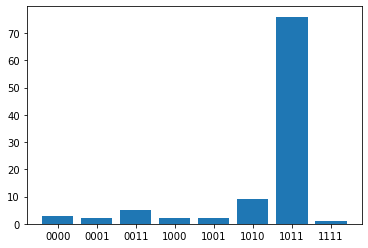

In [32]:
plt.bar(counts.keys(), counts.values())